# Second part : Uncalibrated photometric stereo

In [1]:
import cv2
import os
from matplotlib import pyplot as plt
import numpy as np
import math
import random

## Preprocessing 

In [2]:
# - Read pgm image
fn = 11
img_list = np.empty(0)
source_light = []
for i,file_name in enumerate(os.listdir("./data")) :
    if file_name == "yaleB01_P00_Ambient.pgm" :
        ambient_img = cv2.imread("./data/yaleB01_P00_Ambient.pgm",cv2.IMREAD_GRAYSCALE)
    else :
        image = cv2.imread("./data/" + file_name,cv2.IMREAD_GRAYSCALE)
        img_list = np.append(img_list,image)
        s = (1,math.radians(int(file_name[17:20])),math.radians(int(file_name[12:16])))
        source_light = np.append(source_light,s)
source_light_spherical = np.reshape(source_light,(fn,3))
img_data = np.reshape(img_list,(-1,ambient_img.shape[0],ambient_img.shape[1]))

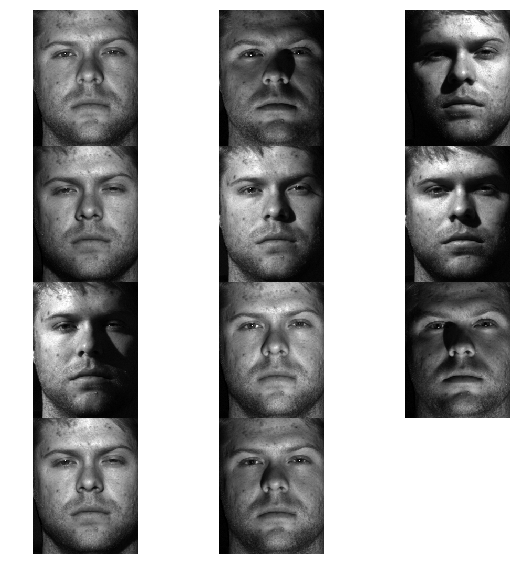

In [3]:
# - Subtract the ambient image from other images
sub_img_data = np.subtract(img_data,ambient_img)

# - Threshold so that no pixel value is smaller than zero
thr_img_data = (sub_img_data > 0) * sub_img_data

# - Crop the images so that only the face regions remain 
# - while the background and hair regions are excluded.
crop_img_data = thr_img_data[:,80:340,240:440] 

# - Print Crop images
fig = plt.figure(figsize=(10,10))
for i, img in enumerate(crop_img_data):
    fig.add_subplot(4, 3, i+1)
    plt.axis("off")
    plt.imshow(img, cmap='gray')
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

## Uncalibrated Photometric stereo

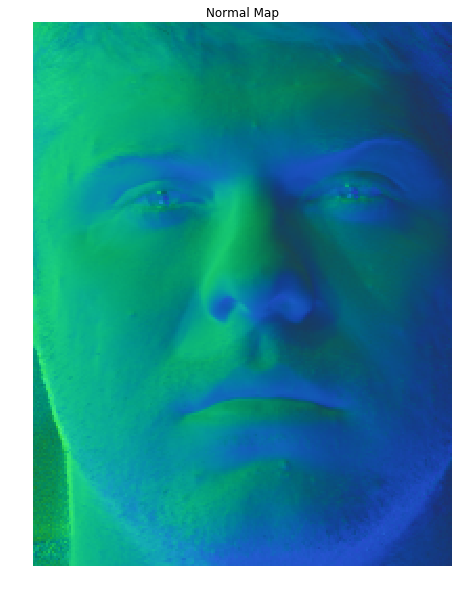

In [4]:
# - get image intensity (shape 11,shape[0] x shape[1])
E = np.reshape(crop_img_data,(fn,-1))

# - Estimate possible surface normal, albedo (B) and light source directions (s) using SVD.
u, s, vh = np.linalg.svd(E, full_matrices=False)

b_ = u[:,0:3]
s_ = vh[0:3,:]
#S_sqrt = np.diag(np.sqrt(s[:3]))
#b_ = np.dot(b_,S_sqrt)
s_ = np.dot(np.diag(s[:3]),s_)
#s__ = np.dot(np.diag(s[:3]),s_)
albedo_map = np.linalg.norm(s_.transpose(),axis=1)
normal_map = s_ / albedo_map
normal_map_ = normal_map
normal_map = np.reshape(normal_map.transpose(),(crop_img_data.shape[1],crop_img_data.shape[2],-1))
# - Display the reconstructed surface normals using color code 
normal_map = (normal_map + 1)/ 2
normal_map = (normal_map*255).astype("uint8")
fig = plt.figure(figsize=(10,10))
fig.add_subplot(1, 1,1)
plt.imshow(normal_map)
plt.axis("off")
plt.title("Normal Map")

plt.subplots_adjust(hspace=0, wspace=2)
plt.show()

## Evaluate result (Data Light source)

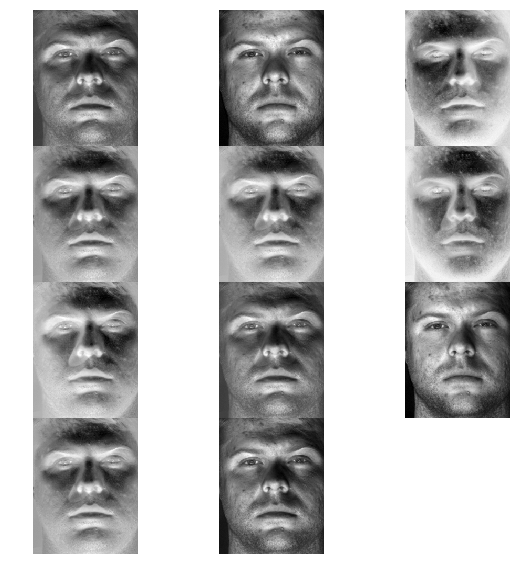

In [5]:
# - Synthesize images with some light source direction s* 
# - which is different from the light sources in s.s = np.dot(source_light,normal_map)

source_light = []
for i in range(len(source_light_spherical)) :
    s = (source_light_spherical[i][0]*math.sin(source_light_spherical[i][1])*math.cos(source_light_spherical[i][2]),
         source_light_spherical[i][0]*math.sin(source_light_spherical[i][1])*math.sin(source_light_spherical[i][2]),
         source_light_spherical[i][0]*math.cos(source_light_spherical[i][1]))
    source_light = np.append(source_light,s)
source_light = np.reshape(source_light,(fn,3))

s = np.dot(source_light,normal_map_*albedo_map)
s = np.reshape(s,(-1,crop_img_data.shape[1],crop_img_data.shape[2]))

fig = plt.figure(figsize=(10,10))
for i, img in enumerate(s):
    fig.add_subplot(4, 3, i+1)
    plt.axis("off")
    plt.imshow(img, cmap='gray')
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

## Evaluate result (Random Light source)

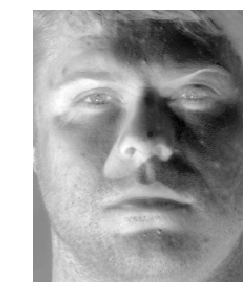

In [8]:
light_source_random = np.array([1,random.random()*180/math.pi,random.random()*360/math.pi])
s = (light_source_random[0]*math.sin(light_source_random[1])*math.cos(light_source_random[2]),
     light_source_random[0]*math.sin(light_source_random[1])*math.sin(light_source_random[2]),
     light_source_random[0]*math.cos(light_source_random[1]))
s = np.dot(light_source_random,normal_map_*albedo_map)
s = np.reshape(s,(crop_img_data.shape[1],crop_img_data.shape[2]))
fig = plt.figure(figsize=(5,5))
fig.add_subplot(1,1,1)
plt.axis("off")
plt.imshow(s, cmap='gray')